In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from numba import njit

from matplotlib import pyplot as plt

### Load reference data

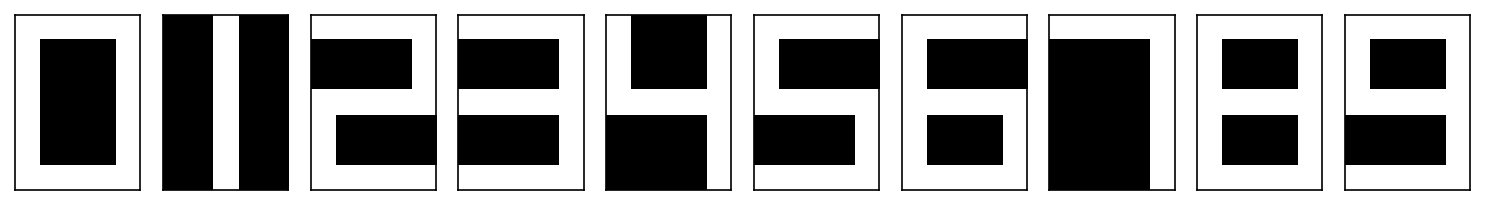

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

img_shape = (7, 5)
img_size = 35

data_path = Path('/mnt/HDD500GB/Data/development/jupyterLab/data/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [3]:
cells_columns = [f'c{n}' for n in range(img_size)]
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

df = pd.DataFrame(columns=cells_columns + ['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, data_mtrx[i]))
    new_row['class'] = classes[i]

    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = data_mtrx[i] + np.random.uniform(0, 0.25, img_size)

        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]

        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

### Split dataset to test and train

In [4]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

x_test = np.array(df.iloc[idx_test][features_columns]).astype(np.float64)
y_test = np.array(df.iloc[idx_test][label_columns]).astype(np.float64)

x_train = np.array(df.iloc[idx_train][features_columns]).astype(np.float64)
y_train = np.array(df.iloc[idx_train][label_columns]).astype(np.float64)

### Define model

In [5]:
@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)


@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, W: np.ndarray, b: np.ndarray, c: np.ndarray) -> tuple[np.ndarray]:
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)
    dc = np.zeros(c.shape)

    h = np.zeros((W.shape[0], W.shape[2]))
    u = np.zeros((W.shape[0], W.shape[1]))

    for i in range(x_batch.shape[0]):
        for j in range(W.shape[0]):
            h[j] = W[j].T @ y_batch[i] + c[j]
            u[j] = W[j] @ x_batch[i] + b[j]
            # u[j] = W[j] @ h[j] + b[j]

        z = np.sum(u, axis=0)
        y = softmax(z)

        dLy_dz = y - y_batch[i]

        for j in range(W.shape[0]):
            dLx_dh = 2 * (h[j] - x_batch[i])
        
            # dLy_dw = np.outer(dLy_dz, h[j])
            dLy_dw = np.outer(dLy_dz, x_batch[i])
            dLx_dw = np.outer(y_batch[i], dLx_dh)

            dW[j] += dLy_dw + dLx_dw
            db[j] += dLy_dz
            dc[j] += dLx_dh

    return (dW, db, dc)


class Perceptron:
    def __init__(self, nIn: int, nOut: int, nL: int) -> None:
        self.nIn = nIn
        self.nOut = nOut
        self.nL = nL

        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nIn))
        self.b: np.ndarray = np.zeros((nL, nOut))
        self.c: np.ndarray = np.zeros((nL, nIn))

    def predict(self, x: np.ndarray) -> np.ndarray:
        z = np.zeros(self.nOut)
        
        for i in range(self.nL):
            z += self.W[i] @ (x - self.c[i]) + self.b[i]

        return softmax(z)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dW, db, dc = grads(x_train[batch_idxs], y_train[batch_idxs], self.W, self.b, self.c)

                self.W -= lr * dW
                self.b -= lr * db
                self.c -= lr * dc

### Create and train model

In [9]:
nIn = 35
nOut = 10
nL = 3

learning_rate = 1e-3
batch_size = 8
max_epoch = 100

model = Perceptron(nIn, nOut, nL)

print('untrained loss: ', model.loss(x_test, y_test).round(4))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: ', model.loss(x_test, y_test).round(4))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  0.7768
trained loss:  0.0182
test set accuracy: 95.0%


### Test model on big number of noised samples

In [10]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    ypred = model.predict(x)
    n_true_pos += 1 if j == np.argmax(ypred) else 0

print(f"accuracy: {round(n_true_pos / n_samples * 100, 2)}% ({n_true_pos} of {n_samples})")

accuracy: 96.37% (9637 of 10000)


### Visualize model predictions

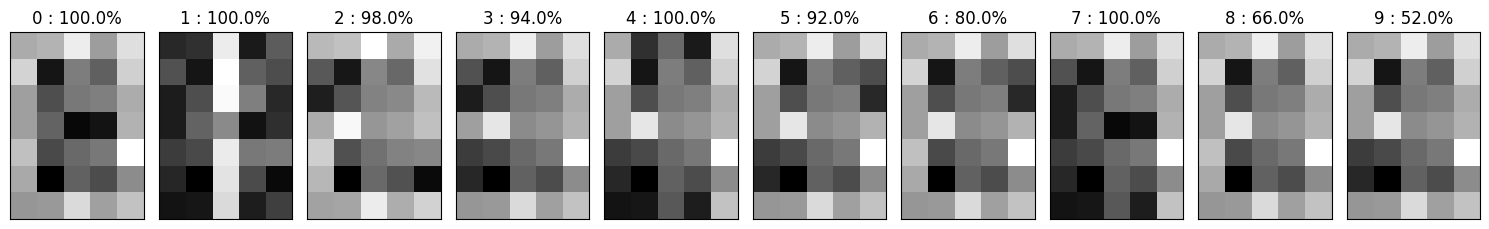

In [11]:
noise_size = 1.0
x_noised = data_mtrx + np.random.uniform(0, noise_size, img_size)

ypred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(ypred[i])

    ax.set_title(f"{j} : {(ypred[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()